# 心电分类模型

In [1]:
# 导入模块
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_filepath = "../data/numpy_data/"

X_train = np.load(data_filepath + 'X_train.npy')
y_train = np.load(data_filepath + 'y_train.npy', allow_pickle=True)
X_test = np.load(data_filepath + 'X_test.npy')
y_test = np.load(data_filepath + 'y_test.npy', allow_pickle=True)

# reshape y_train, y_test
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

In [3]:
def shuffle_train_test(X_train, y_train, X_test, y_test):
    shuffled_indices_x = np.random.permutation(len(y_train))
    shuffled_indices_y = np.random.permutation(len(y_test))

    return X_train[shuffled_indices_x], y_train[shuffled_indices_x], X_test[shuffled_indices_y], y_test[shuffled_indices_y]

In [4]:
# 打乱数据
X_train, y_train, X_test, y_test = shuffle_train_test(X_train, y_train, X_test, y_test)

## 查看数据并调整数据格式

### 查看输入x和标签的维度是否匹配

In [5]:
X_train.shape

(16966, 500, 12)

In [6]:
y_train.shape

(16966, 1)

In [7]:
X_test.shape

(1901, 500, 12)

y_test.shape

### 将y映射为数组

In [8]:
num2class = np.array(['NORM', 'MI', 'STTC', 'CD', 'HYP'])

In [9]:
np.where(num2class == 'STTC')[0][0]

2

In [10]:
for index in range(len(y_train)):
    y_train[index] = np.where(num2class == y_train[index][0][0])[0]

In [11]:
for index in range(len(y_test)):
    y_test[index] = np.where(num2class == y_test[index][0][0])[0]

In [12]:
y_train = y_train.reshape(1, -1)[0].astype('uint8')
y_test = y_test.reshape(1, -1)[0].astype('uint8')

In [13]:
y_test

array([0, 4, 2, ..., 3, 2, 3], dtype=uint8)

In [14]:
y_train_norm = (y_train == 0).reshape(1, -1)[0]
y_test_norm = (y_test == 0).reshape(1, -1)[0]

## PCA降维

In [15]:
from sklearn.decomposition import PCA

### 训练集PCA降维

In [16]:
X_train_flatten = X_train.reshape(len(X_train), 6000)
pca_train = PCA(n_components=180)
pca_train.fit(X_train_flatten)

PCA(copy=True, iterated_power='auto', n_components=180, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
X_train_pca = pca_train.fit_transform(X_train_flatten)

In [18]:
pca_train.explained_variance_ratio_.sum()

0.9796381837476826

In [19]:
X_train_pca.shape

(16966, 180)

### 测试集PCA降维

In [21]:
X_test_flatten = X_test.reshape(len(X_test), 6000)
pca_test = PCA(n_components=180)
pca_test = PCA(X_test_flatten)

In [22]:
X_test_pca = pca_train.fit_transform(X_test_flatten)

In [23]:
X_test_pca.shape

(1901, 180)

## 训练模型 

### 二分类模型

In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [25]:
sgd_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd_clf", SGDClassifier(random_state=42))
])
sgd_clf.fit(X_train_pca, y_train_norm)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgd_clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=42,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [26]:
y_predict = sgd_clf.predict(X_test_pca)
y_predict[0:10]

array([False, False, False, False, False, False, False,  True, False,
        True])

In [27]:
y_test_norm[0:10]

array([ True, False, False, False,  True, False, False,  True, False,
       False])

#### K折交叉验证

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

def k_fold_val(classifier, k_fold=5):
    skfolds = StratifiedKFold(n_splits=5, random_state=42)
    fold = 1
    total_accu = 0
    for train_index, test_index in skfolds.split(X_train_pca, y_train_norm):
        clone_clf = clone(classifier)
        X_train_folds = X_train_pca[train_index]
        y_train_folds = y_train_norm[train_index]
        X_test_fold = X_train_pca[test_index]
        y_test_fold = y_train_norm[test_index]
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print("Fold %d accuracy: %f"%(fold, n_correct / len(y_pred)))
        fold += 1
        total_accu += n_correct / len(y_pred)
    print("\nTotal Accuracy: %f" % (total_accu/k_fold))


In [29]:
k_fold_val(sgd_clf)

Fold 1 accuracy: 0.710961
Fold 2 accuracy: 0.730032
Fold 3 accuracy: 0.712938
Fold 4 accuracy: 0.712349
Fold 5 accuracy: 0.719422

Total Accuracy: 0.717141


In [30]:
from sklearn.model_selection import cross_val_score

In [31]:
cross_val_score(sgd_clf, X_train_pca, y_train_norm, cv=5, scoring="accuracy")

array([0.71096052, 0.73003242, 0.7129384 , 0.71234895, 0.71942234])

#### 查看混淆矩阵

In [32]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train_pca, y_train_norm, cv=5)
confusion_matrix(y_train_norm, y_train_pred)

array([[7403, 2347],
       [2452, 4764]])

In [34]:
from sklearn.metrics import precision_score, recall_score

In [35]:
precision_score(y_train_norm, y_train_pred)

0.6699479679369991

In [36]:
recall_score(y_train_norm, y_train_pred)

0.6601995565410199

In [37]:
from sklearn.metrics import f1_score

In [38]:
f1_score(y_train_norm, y_train_pred)

0.6650380400642144

#### ROC曲线

In [39]:
from sklearn.metrics import roc_curve

y_scores = cross_val_predict(sgd_clf, X_train_pca, y_train_norm, cv=5,
method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train_norm, y_scores)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

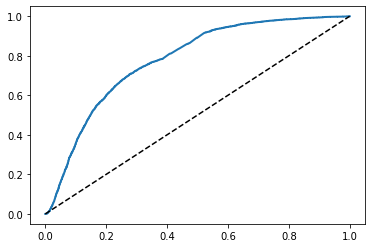

In [41]:
plot_roc_curve(fpr, tpr)
plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_norm, y_scores)

0.7786354824037751

### 随机森林模型

In [43]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train_pca, y_train_norm, cv=5,method="predict_proba")

In [44]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_norm, y_scores_forest)

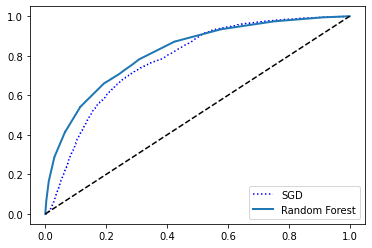

In [45]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [46]:
roc_auc_score(y_train_norm, y_scores_forest)

0.8171341818750354

In [47]:
y_train_pred = (y_scores_forest>=0.5)

In [48]:
confusion_matrix(y_train_norm, y_train_pred)

array([[7871, 1879],
       [2453, 4763]])

In [49]:
precision_score(y_train_norm, y_train_pred)

0.7171032821439326

In [50]:
recall_score(y_train_norm, y_train_pred)

0.6600609756097561

In [51]:
f1_score(y_train_norm, y_train_pred)

0.6874007793332371

### 支持向量机模型

In [52]:
from sklearn.svm import LinearSVC

In [53]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=3, loss="hinge")),
])

In [54]:
svm_clf.fit(X_train_pca, y_train_norm)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=3, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [55]:
y_train_pred = svm_clf.predict(X_train_pca)

In [56]:
y_probas_svm = cross_val_predict(svm_clf, X_train_pca, y_train_norm, cv=5,method="decision_function")
y_probas_svm

array([ 1.3295124 ,  1.3024912 , -0.77831712, ...,  1.27460877,
        1.33974842, -0.42853455])

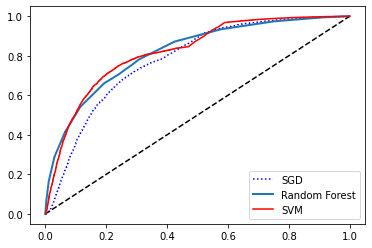

0.8214919694127012

In [57]:
fpr_svm, tpr_svm, threshold_forest = roc_curve(y_train_norm, y_probas_svm)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_svm, tpr_svm, 'r', label="SVM")
plt.legend(loc="lower right")
plt.show()
roc_auc_score(y_train_norm, y_probas_svm)

In [58]:
confusion_matrix(y_train_norm, y_train_pred)

array([[7914, 1836],
       [2132, 5084]])

In [59]:
precision_score(y_train_norm, y_train_pred)

0.7346820809248555

In [60]:
recall_score(y_train_norm, y_train_pred)

0.7045454545454546

In [61]:
f1_score(y_train_norm, y_train_pred)

0.7192982456140351

## 支持向量机多分类

In [62]:
sgd_clf.fit(X_train_pca, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgd_clf',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=42,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [63]:
sgd_clf.predict(X_test_pca)

array([3, 2, 3, ..., 4, 0, 0], dtype=uint8)

In [64]:
some_digit_scores = sgd_clf.decision_function([X_test_pca[100]])

In [65]:
some_digit_scores

array([[-1.25718366, -2.08630245, -1.27821547, -1.74088378, -3.52112181]])

In [66]:
np.argmax(some_digit_scores)

0

In [67]:
y_test[100]

0

In [68]:
sgd_clf.classes_

array([0, 1, 2, 3, 4], dtype=uint8)

In [69]:
y_train_pred = cross_val_predict(sgd_clf, X_train_pca, y_train, cv=5)

In [70]:
confusion_matrix(y_train, y_train_pred)

array([[5509,  165,  209, 1197,  136],
       [ 769,  339,  241,  574,  109],
       [ 762,  197,  565,  661,  218],
       [1064,  355,  354, 1876,  214],
       [ 328,   89,  164,  337,  534]])

In [71]:
cross_val_score(sgd_clf, X_train_pca, y_train, cv=5, scoring="accuracy")

array([0.52532391, 0.50662739, 0.51635721, 0.53818932, 0.51371277])

In [72]:
cross_val_score(sgd_clf, X_train_pca, y_train, cv=5, scoring="accuracy")

array([0.52532391, 0.50662739, 0.51635721, 0.53818932, 0.51371277])